In [2]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import geobr
import geopandas as gpd
import matplotlib as mpl

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()


In [3]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = '14'
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
file_path = './1 - Organized data gauge/BRAZIL/DATASETS/BRAZIL_DAILY_1961_2024_CLEANED.h5'

In [5]:
def calculate_quality_label(row):
    if row['quality_index'] >= 90 and row['p_availability'] >= 99:
        return '1 - Excellent Quality'
    elif row['quality_index'] >= 85 and row['p_availability'] >= 95:
        return '2 - Good Quality'
    elif row['quality_index'] >= 80 and row['p_availability'] >= 90:
        return '3 - Acceptable Quality'
    elif row['quality_index'] >= 50:
        return '4 - Low Quality'
    else:
        return '5 - Very Low Quality'

In [6]:
with h5py.File(file_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers']


In [7]:
df_p_availability = pd.read_hdf(file_path, key = 'table_p_availability', encoding = 'utf-8')
df_q1_gaps = pd.read_hdf(file_path, key = 'table_q1_gaps', encoding = 'utf-8')
df_q2_week = pd.read_hdf(file_path, key = 'table_q2_week', encoding = 'utf-8')
df_q3_outliers = pd.read_hdf(file_path, key = 'table_q3_outliers', encoding = 'utf-8')
df_preclassif = pd.read_hdf(file_path, key = 'table_preclassif', encoding = 'utf-8')
df_info = pd.read_hdf(file_path, key = 'table_info', encoding = 'utf-8')
df_preclassif

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,00047000,1961,2186.0,365.0,265.0,LQ
1,00047000,1962,273.8,365.0,93.0,
2,00047000,1963,686.2,365.0,71.0,
3,00047000,1964,597.5,366.0,93.0,
4,00047002,1977,133.4,23.0,5.0,LQ
...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ
345864,S714,2021,828.0,365.0,58.0,
345865,S715,2021,1041.8,365.0,38.0,
345866,S716,2021,928.8,365.0,32.0,


In [8]:
df_qc_info = pd.merge(df_preclassif
                      , df_p_availability
                      , on = ['gauge_code', 'year']
                      , how='left').merge(df_q1_gaps
                                          , on = ['gauge_code', 'year']
                                          , how='left').merge(df_q2_week
                                                              , on = ['gauge_code', 'year']
                                                              , how='left').merge(df_q3_outliers
                                                                                  , on = ['gauge_code', 'year']
                                                                                  , how='left')
df_qc_info.fillna(0, inplace=True)
df_qc_info

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif,p_availability,q1_gaps,q2_week,q3_outliers
0,00047000,1961,2186.0,365.0,265.0,LQ,100.00000,100.0,71.803161,98.082192
1,00047000,1962,273.8,365.0,93.0,,100.00000,100.0,69.402386,99.452055
2,00047000,1963,686.2,365.0,71.0,,100.00000,100.0,66.650234,99.726027
3,00047000,1964,597.5,366.0,93.0,,100.00000,100.0,87.798731,99.726776
4,00047002,1977,133.4,23.0,5.0,LQ,6.30137,0.0,6.458565,91.304348
...,...,...,...,...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ,100.00000,100.0,62.583426,99.726027
345864,S714,2021,828.0,365.0,58.0,,100.00000,100.0,63.664531,99.178082
345865,S715,2021,1041.8,365.0,38.0,,100.00000,100.0,76.074189,98.630137
345866,S716,2021,928.8,365.0,32.0,,100.00000,100.0,74.501053,98.904110


In [9]:
df_qc_info['quality_index'] = (df_qc_info['p_availability'] + df_qc_info['q1_gaps'] + df_qc_info['q2_week'] + df_qc_info['q3_outliers'])/4
df_qc_info.describe()

,year,annual_rainfall_mm,active_days,consecutive_dry_days,p_availability,q1_gaps,q2_week,q3_outliers,quality_index
count,345868.000000,345868.000000,345868.000000,345868.000000,345868.000000,345868.000000,345868.000000,345868.000000,345868.000000
mean,1992.056756,1198.082943,357.351131,68.939225,97.835382,96.422459,69.812925,98.661822,90.683147
std,17.912871,708.897542,43.049171,86.242928,11.786879,17.898330,23.121761,1.147182,9.972863
min,1961.000000,0.000000,1.000000,0.000000,0.273224,0.000000,0.000000,0.000000,0.068306
25%,1977.000000,724.100000,365.000000,22.000000,100.000000,100.000000,67.314100,98.082192,91.217808
50%,1991.000000,1212.000000,365.000000,38.000000,100.000000,100.000000,77.205487,98.904110,93.879223
75%,2007.000000,1601.000000,365.000000,74.000000,100.000000,100.000000,83.363224,99.452055,95.387871
max,2024.000000,25392.200000,366.000000,366.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [10]:
df_qc_info['quality_label'] = df_qc_info.apply(calculate_quality_label, axis=1)
df_qc_info = pd.merge(df_qc_info, df_info, on = 'gauge_code', how='left')
df_qc_info

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,quality_index,quality_label,name_station,city,state,responsible,source,state_abbreviation,lat,long
0,00047000,1961,2186.0,365.0,265.0,LQ,100.00000,100.0,71.803161,98.082192,92.471338,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000
1,00047000,1962,273.8,365.0,93.0,,100.00000,100.0,69.402386,99.452055,92.213610,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000
2,00047000,1963,686.2,365.0,71.0,,100.00000,100.0,66.650234,99.726027,91.594065,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000
3,00047000,1964,597.5,366.0,93.0,,100.00000,100.0,87.798731,99.726776,96.881377,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000
4,00047002,1977,133.4,23.0,5.0,LQ,6.30137,0.0,6.458565,91.304348,26.016071,5 - Very Low Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ,100.00000,100.0,62.583426,99.726027,90.577363,1 - Excellent Quality,NOVA ANDRADINA | S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833
345864,S714,2021,828.0,365.0,58.0,,100.00000,100.0,63.664531,99.178082,90.710653,1 - Excellent Quality,PEDRO GOMES | S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889
345865,S715,2021,1041.8,365.0,38.0,,100.00000,100.0,76.074189,98.630137,93.676081,1 - Excellent Quality,RIBAS DO RIO PARDO | S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028
345866,S716,2021,928.8,365.0,32.0,,100.00000,100.0,74.501053,98.904110,93.351291,1 - Excellent Quality,SANTA RITA DO PARDO | S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375


In [11]:
# Count rows grouped by 'quality_label'
qc_count = df_qc_info.groupby('quality_label').size().reset_index(name='count')

print(qc_count)


            quality_label   count
0   1 - Excellent Quality  276145
1        2 - Good Quality   25884
2  3 - Acceptable Quality    6141
3         4 - Low Quality   31415
4    5 - Very Low Quality    6283


In [12]:
# Create a dictionary with state abbreviations and corresponding regions in English
state_region_dict = {
    'AC': 'North', 'AL': 'Northeast', 'AP': 'North', 'AM': 'North', 'BA': 'Northeast',
    'CE': 'Northeast', 'DF': 'Central-West', 'ES': 'Southeast', 'GO': 'Central-West',
    'MA': 'Northeast', 'MT': 'Central-West', 'MS': 'Central-West', 'MG': 'Southeast',
    'PA': 'North', 'PB': 'Northeast', 'PR': 'South', 'PE': 'Northeast', 'PI': 'Northeast',
    'RJ': 'Southeast', 'RN': 'Northeast', 'RS': 'South', 'RO': 'North', 'RR': 'North',
    'SC': 'South', 'SP': 'Southeast', 'SE': 'Northeast', 'TO': 'North'
}

# Map the regions to the df_qc_info dataframe
df_qc_info['region'] = df_qc_info['state_abbreviation'].map(state_region_dict)
df_qc_info


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,...,quality_label,name_station,city,state,responsible,source,state_abbreviation,lat,long,region
0,00047000,1961,2186.0,365.0,265.0,LQ,100.00000,100.0,71.803161,98.082192,...,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North
1,00047000,1962,273.8,365.0,93.0,,100.00000,100.0,69.402386,99.452055,...,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North
2,00047000,1963,686.2,365.0,71.0,,100.00000,100.0,66.650234,99.726027,...,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North
3,00047000,1964,597.5,366.0,93.0,,100.00000,100.0,87.798731,99.726776,...,1 - Excellent Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North
4,00047002,1977,133.4,23.0,5.0,LQ,6.30137,0.0,6.458565,91.304348,...,5 - Very Low Quality,SALINÓPOLIS,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ,100.00000,100.0,62.583426,99.726027,...,1 - Excellent Quality,NOVA ANDRADINA | S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,Central-West
345864,S714,2021,828.0,365.0,58.0,,100.00000,100.0,63.664531,99.178082,...,1 - Excellent Quality,PEDRO GOMES | S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,Central-West
345865,S715,2021,1041.8,365.0,38.0,,100.00000,100.0,76.074189,98.630137,...,1 - Excellent Quality,RIBAS DO RIO PARDO | S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,Central-West
345866,S716,2021,928.8,365.0,32.0,,100.00000,100.0,74.501053,98.904110,...,1 - Excellent Quality,SANTA RITA DO PARDO | S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,Central-West


In [13]:
df_qc_info['final_classif'] = df_qc_info.apply(
    lambda row: 'LQ' if row['preclassif'] == 'LQ' or row['quality_label'] in ['4 - Low Quality', '5 - Very Low Quality'] else 'HQ',
    axis=1
)
df_qc_info[['preclassif', 'quality_label', 'final_classif']].head(30)

,preclassif,quality_label,final_classif
0,LQ,1 - Excellent Quality,LQ
1,,1 - Excellent Quality,HQ
2,,1 - Excellent Quality,HQ
3,,1 - Excellent Quality,HQ
4,LQ,5 - Very Low Quality,LQ
5,,1 - Excellent Quality,HQ
6,,1 - Excellent Quality,HQ
7,,1 - Excellent Quality,HQ
8,,1 - Excellent Quality,HQ
9,,1 - Excellent Quality,HQ


In [14]:
df_qc_info.to_hdf(file_path, key='table_qc_info', mode='r+', encoding='utf-8')
df_qc_info

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,...,name_station,city,state,responsible,source,state_abbreviation,lat,long,region,final_classif
0,00047000,1961,2186.0,365.0,265.0,LQ,100.00000,100.0,71.803161,98.082192,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,LQ
1,00047000,1962,273.8,365.0,93.0,,100.00000,100.0,69.402386,99.452055,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
2,00047000,1963,686.2,365.0,71.0,,100.00000,100.0,66.650234,99.726027,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
3,00047000,1964,597.5,366.0,93.0,,100.00000,100.0,87.798731,99.726776,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
4,00047002,1977,133.4,23.0,5.0,LQ,6.30137,0.0,6.458565,91.304348,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,North,LQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ,100.00000,100.0,62.583426,99.726027,...,NOVA ANDRADINA | S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,Central-West,LQ
345864,S714,2021,828.0,365.0,58.0,,100.00000,100.0,63.664531,99.178082,...,PEDRO GOMES | S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,Central-West,HQ
345865,S715,2021,1041.8,365.0,38.0,,100.00000,100.0,76.074189,98.630137,...,RIBAS DO RIO PARDO | S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,Central-West,HQ
345866,S716,2021,928.8,365.0,32.0,,100.00000,100.0,74.501053,98.904110,...,SANTA RITA DO PARDO | S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,Central-West,HQ


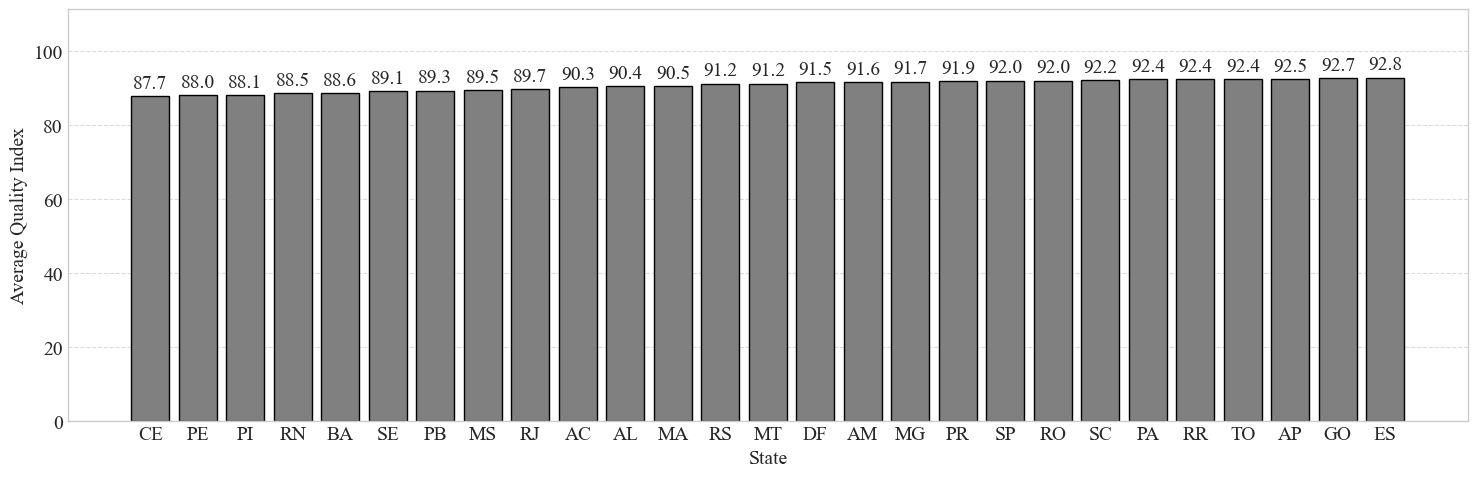

In [15]:
# Calculate the average quality index by state_abbreviation
df_avg_quality_by_state = df_qc_info.groupby('state_abbreviation')['quality_index'].mean().reset_index()
df_avg_quality_by_state['quality_index'] = df_avg_quality_by_state['quality_index'].round(1)
df_avg_quality_by_state.sort_values('quality_index', ascending=True, inplace=True)

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the bar chart
bars = ax.bar(df_avg_quality_by_state['state_abbreviation'], df_avg_quality_by_state['quality_index'], color='grey', edgecolor='black')
ax.set_ylim(0, df_avg_quality_by_state['quality_index'].max() * 1.2)

# Add labels, title, and grid
ax.set_xlabel('State')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index by State')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

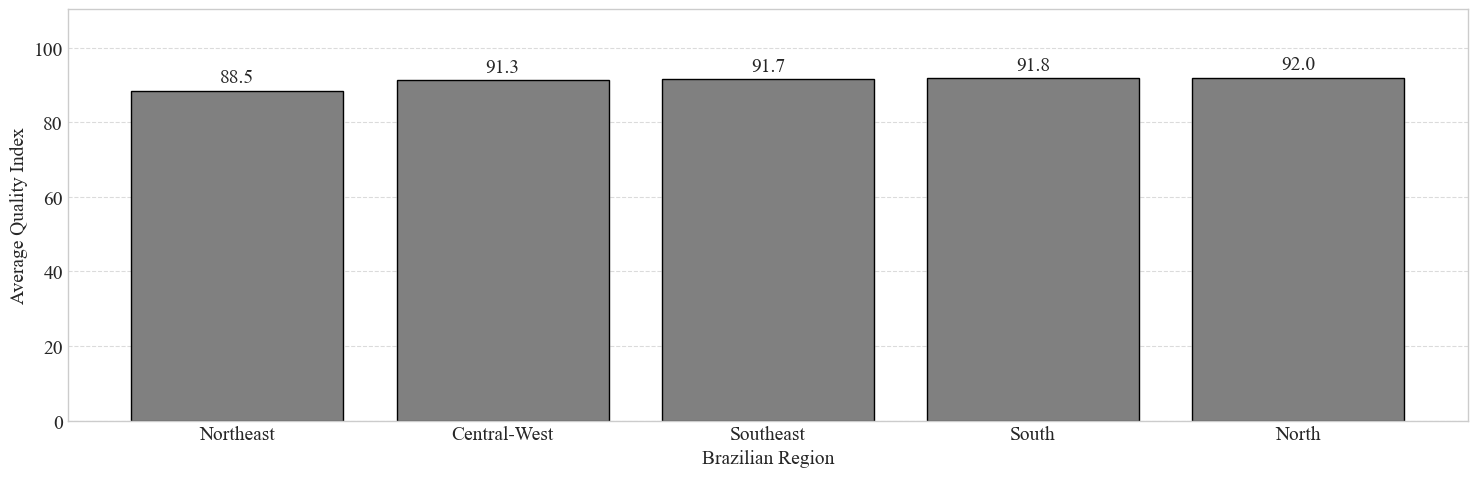

In [16]:
# Calculate the average quality index by region
df_avg_quality_by_region = df_qc_info.groupby('region')['quality_index'].mean().reset_index()
df_avg_quality_by_region['quality_index'] = df_avg_quality_by_region['quality_index'].round(1)
df_avg_quality_by_region.sort_values('quality_index', ascending=True, inplace=True)

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the bar chart
bars = ax.bar(df_avg_quality_by_region['region'], df_avg_quality_by_region['quality_index'], color='grey', edgecolor='black')
ax.set_ylim(0, df_avg_quality_by_region['quality_index'].max() * 1.2)

# Add labels, title, and grid
ax.set_xlabel('Brazilian Region')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index by Region')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

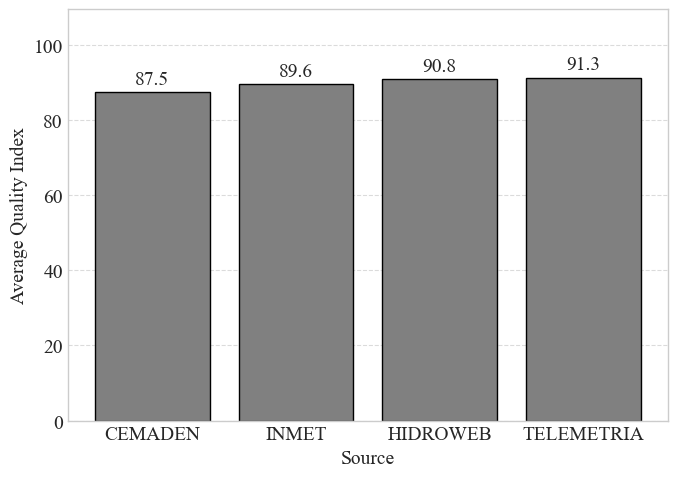

In [17]:
# Calculate the average quality index by source
df_avg_quality_by_source = df_qc_info.groupby('source')['quality_index'].mean().reset_index()
df_avg_quality_by_source['quality_index'] = df_avg_quality_by_source['quality_index'].round(1)
df_avg_quality_by_source.sort_values('quality_index', ascending=True, inplace=True)

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the bar chart
bars = ax.bar(df_avg_quality_by_source['source'], df_avg_quality_by_source['quality_index'], color='grey', edgecolor='black')
ax.set_ylim(0, df_avg_quality_by_source['quality_index'].max() * 1.2)

# Add labels, title, and grid
ax.set_xlabel('Source')
ax.set_ylabel('Average Quality Index')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [18]:
br_map = geobr.read_state(year = 2020)
br_map.crs = "EPSG:4326"
br_map['name_state'] = br_map['name_state'].apply(str.upper)
br_map = br_map.sort_values(by = ['name_state'])
br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)
br_map.head()

C:\Users\linde\AppData\Local\Temp\ipykernel_3932\948283981.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)


,code_state,abbrev_state,name_state,code_region,name_region,geometry
1,12.0,AC,ACRE,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.07817 ..."
13,27.0,AL,ALAGOAS,2.0,Nordeste,"MULTIPOLYGON (((-35.75791 -9.69285, -35.75801 ..."
5,16.0,AP,AMAPÁ,1.0,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2..."
2,13.0,AM,AMAZONAS,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.82555 ..."
15,29.0,BA,BAHIA,2.0,Nordeste,"MULTIPOLYGON (((-38.69616 -17.97901, -38.69618..."


In [19]:
br_map_count = br_map.merge(df_avg_quality_by_state, left_on='abbrev_state', right_on='state_abbreviation', how='left')
br_map_count = br_map_count.sort_values(by = ['name_state'])
br_map_count = gpd.GeoDataFrame(br_map_count)
br_map_count['centroid'] = gpd.GeoSeries(br_map_count['geometry']).centroid
br_map_count = gpd.GeoDataFrame(br_map_count)
br_map_count

C:\Users\linde\AppData\Local\Temp\ipykernel_3932\326786035.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  br_map_count['centroid'] = gpd.GeoSeries(br_map_count['geometry']).centroid


,code_state,abbrev_state,name_state,code_region,name_region,geometry,state_abbreviation,quality_index,centroid
0,12.0,AC,ACRE,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.07817 ...",AC,90.3,POINT (-70.47293 -9.21327)
1,27.0,AL,ALAGOAS,2.0,Nordeste,"MULTIPOLYGON (((-35.75791 -9.69285, -35.75801 ...",AL,90.4,POINT (-36.62485 -9.51367)
2,16.0,AP,AMAPÁ,1.0,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",AP,92.5,POINT (-51.96202 1.44746)
3,13.0,AM,AMAZONAS,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.82555 ...",AM,91.6,POINT (-64.65309 -4.15410)
4,29.0,BA,BAHIA,2.0,Nordeste,"MULTIPOLYGON (((-38.69616 -17.97901, -38.69618...",BA,88.6,POINT (-41.72116 -12.47533)
5,23.0,CE,CEARÁ,2.0,Nordeste,"MULTIPOLYGON (((-41.18292 -4.01797, -41.18552 ...",CE,87.7,POINT (-39.61579 -5.09322)
6,53.0,DF,DISTRITO FEDERAL,5.0,Centro Oeste,"MULTIPOLYGON (((-47.41734 -15.54655, -47.41720...",DF,91.5,POINT (-47.79685 -15.78117)
7,32.0,ES,ESPÍRITO SANTO,3.0,Sudeste,"MULTIPOLYGON (((-40.75189 -20.92722, -40.75193...",ES,92.8,POINT (-40.66851 -19.57518)
8,52.0,GO,GOIÁS,5.0,Centro Oeste,"MULTIPOLYGON (((-52.36102 -16.08160, -52.36040...",GO,92.7,POINT (-49.62251 -16.04119)
9,21.0,MA,MARANHÃO,2.0,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ...",MA,90.5,POINT (-45.28777 -5.07221)


C:\Users\linde\AppData\Local\Temp\ipykernel_3932\2234521622.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_map_count.centroid.x, br_map_count.centroid.y, br_map_count.quality_index):


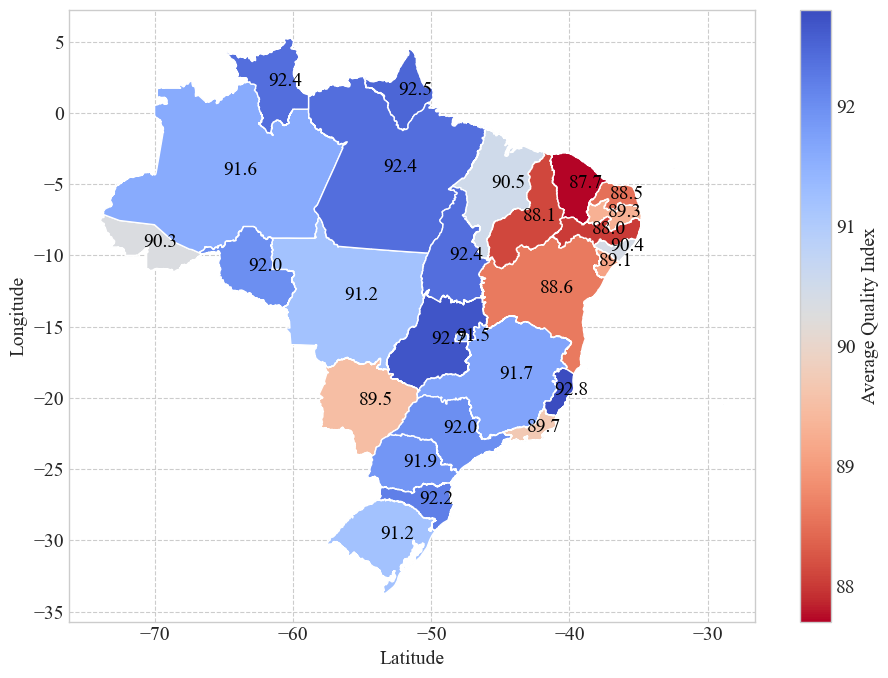

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
br_map_count.plot(ax=ax, edgecolor='white', column='quality_index', legend=False, cmap='coolwarm_r', alpha=1.0)
# ax.set_title("Average Quality Index by Brazilian state", fontsize=14, fontname="Times New Roman")

# Adding labels to each point
for x, y, label in zip(br_map_count.centroid.x, br_map_count.centroid.y, br_map_count.quality_index):
    ax.annotate(label, xy=(x, y), xytext=(-4, -2), textcoords="offset points", color="black", rotation=0)

# Adding colorbar
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(br_map_count['quality_index'].min(), br_map_count['quality_index'].max()), cmap='coolwarm_r'),
             ax=ax, orientation='vertical', label='Average Quality Index')

# ax.set_ylim([-35, 7])
# ax.set_xlim([-75, -33])
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.grid(ls='--')
plt.tight_layout()
plt.savefig('./figures/average_quality_index_by_state_1961_2024.jpeg', format='jpeg', dpi=1200, transparent=False, bbox_inches=None)
plt.show()
plt.close()

In [21]:
df_qc_info

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,...,name_station,city,state,responsible,source,state_abbreviation,lat,long,region,final_classif
0,00047000,1961,2186.0,365.0,265.0,LQ,100.00000,100.0,71.803161,98.082192,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,LQ
1,00047000,1962,273.8,365.0,93.0,,100.00000,100.0,69.402386,99.452055,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
2,00047000,1963,686.2,365.0,71.0,,100.00000,100.0,66.650234,99.726027,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
3,00047000,1964,597.5,366.0,93.0,,100.00000,100.0,87.798731,99.726776,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,North,HQ
4,00047002,1977,133.4,23.0,5.0,LQ,6.30137,0.0,6.458565,91.304348,...,SALINÓPOLIS,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,North,LQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,S713,2021,76.2,365.0,137.0,LQ,100.00000,100.0,62.583426,99.726027,...,NOVA ANDRADINA | S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,Central-West,LQ
345864,S714,2021,828.0,365.0,58.0,,100.00000,100.0,63.664531,99.178082,...,PEDRO GOMES | S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,Central-West,HQ
345865,S715,2021,1041.8,365.0,38.0,,100.00000,100.0,76.074189,98.630137,...,RIBAS DO RIO PARDO | S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,Central-West,HQ
345866,S716,2021,928.8,365.0,32.0,,100.00000,100.0,74.501053,98.904110,...,SANTA RITA DO PARDO | S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,Central-West,HQ


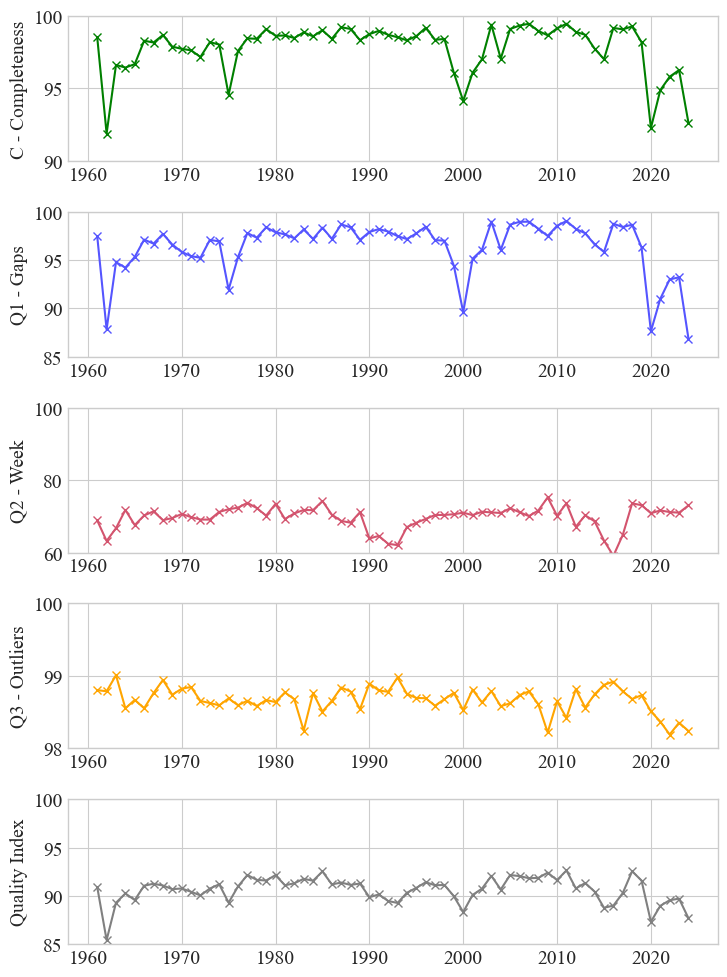

In [22]:
# Calculate the average value of each parameter by year
df_avg_params = df_qc_info.groupby('year').agg({
    'p_availability': 'mean',
    'q1_gaps': 'mean',
    'q2_week': 'mean',
    'q3_outliers': 'mean',
    'quality_index': 'mean'
}).reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(5, 1, figsize=(7.5, 10), sharex=True)

# Plot each parameter
ax0 = ax[0]
ax0.plot(df_avg_params['year'], df_avg_params['p_availability'], marker='x', color='g', label='C - Completeness')
ax0.set_ylim(90, 100)
ax0.set_ylabel('C - Completeness')
ax0.grid(True)

# lines, labels = ax0.get_legend_handles_labels()
# legend = ax0.legend(lines , labels + labels, loc='lower center')
# legend.set_frame_on(True)  # Ensure frame is visible
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('grey')
# frame.set_linewidth(0.5)


ax1 = ax[1]
ax1.plot(df_avg_params['year'], df_avg_params['q1_gaps'], marker='x', color='#5555ff', label='Q1 - Gaps')
ax1.set_ylabel('Q1 - Gaps')
ax1.set_ylim(85, 100)
ax1.grid(True)

# lines, labels = ax1.get_legend_handles_labels()
# legend = ax1.legend(lines , labels + labels, loc='lower center')
# legend.set_frame_on(True)  # Ensure frame is visible
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('grey')
# frame.set_linewidth(0.5)


ax2 = ax[2]
ax2.plot(df_avg_params['year'], df_avg_params['q2_week'], marker='x', color='#d3546e', label='Q2 - Week')
ax2.set_ylabel('Q2 - Week')
ax2.set_ylim(60, 100)
ax2.grid(True)

# lines, labels = ax2.get_legend_handles_labels()
# legend = ax2.legend(lines , labels + labels, loc='upper center')
# legend.set_frame_on(True)  # Ensure frame is visible
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('grey')
# frame.set_linewidth(0.5)


ax3 = ax[3]
ax3.plot(df_avg_params['year'], df_avg_params['q3_outliers'], marker='x', color='orange', label='Q3 - Outliers')
ax3.set_ylim(98, 100)
ax3.set_ylabel('Q3 - Outliers')
ax3.grid(True)

# lines, labels = ax3.get_legend_handles_labels()
# legend = ax3.legend(lines , labels + labels, loc='upper center')
# legend.set_frame_on(True)  # Ensure frame is visible
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('grey')
# frame.set_linewidth(0.5)

ax4 = ax[4]
ax4.set_ylim(85, 100)
ax4.plot(df_avg_params['year'], df_avg_params['quality_index'], marker='x', color='grey', label='Quality Index')
# ax4.set_xlabel('Year')
ax4.set_ylabel('Quality Index')
ax4.grid(True)

# lines, labels = ax4.get_legend_handles_labels()
# legend = ax4.legend(lines , labels + labels, loc='upper center')
# legend.set_frame_on(True)  # Ensure frame is visible
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('grey')
# frame.set_linewidth(0.5)

# Show xticks on all subplots
for a in ax:
    a.label_outer()  # Hides labels except for the last subplot but keeps ticks visible
    a.tick_params(axis='x', which='both', labelbottom=True)  # Ensure xticks are visible
    
plt.tight_layout()
plt.savefig('./figures/quality_index_avg_year.tiff', dpi = 300)
plt.show()
plt.close()

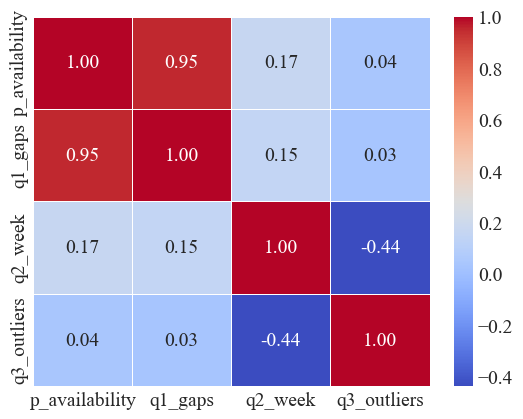

In [23]:
# Select relevant columns for the heatmap
heatmap_data = df_qc_info[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers']]

# Calculate the correlation matrix
corr = heatmap_data.corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Heatmap of df_qc_info Parameters')
plt.show()

In [24]:
df_qc_count = df_qc_info.groupby('quality_label').size().reset_index(name='count')
df_qc_count['percent'] = (df_qc_count['count'] / df_qc_count['count'].sum()) * 100
df_qc_count

,quality_label,count,percent
0,1 - Excellent Quality,276145,79.841153
1,2 - Good Quality,25884,7.483780
2,3 - Acceptable Quality,6141,1.775533
3,4 - Low Quality,31415,9.082945
4,5 - Very Low Quality,6283,1.816589


In [25]:
df_qc_avg = df_qc_info.groupby('quality_label').agg({'p_availability': 'mean'
                                                     , 'q1_gaps':'mean'
                                                     , 'q2_week':'mean'
                                                     , 'q3_outliers':'mean'
                                                     }).reset_index()
df_qc_avg

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers
0,1 - Excellent Quality,99.996959,99.991153,78.882356,98.488234
1,2 - Good Quality,99.931966,99.801365,54.101522,99.202054
2,3 - Acceptable Quality,98.726765,96.195497,39.870192,99.310407
3,4 - Low Quality,91.547442,81.556356,16.008409,99.637171
4,5 - Very Low Quality,24.762822,0.206611,34.215782,98.554948


In [26]:
df_qc_min = df_qc_info.groupby('quality_label').agg({'p_availability': 'min'
                                                     , 'q1_gaps':'min'
                                                     , 'q2_week':'min'
                                                     , 'q3_outliers':'min'
                                                     }).reset_index()
df_qc_min

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers
0,1 - Excellent Quality,99.178082,97.534247,60.000000,74.794521
1,2 - Good Quality,95.068493,85.205479,40.000000,69.589041
2,3 - Acceptable Quality,90.136986,70.410959,20.026785,90.029326
3,4 - Low Quality,7.123288,0.000000,0.000000,83.425414
4,5 - Very Low Quality,0.273224,0.000000,0.000000,0.000000


In [27]:
df_qc_max = df_qc_info.groupby('quality_label').agg({'p_availability': 'max'
                                                     , 'q1_gaps':'max'
                                                     , 'q2_week':'max'
                                                     , 'q3_outliers':'max'
                                                     }).reset_index()
df_qc_max

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers
0,1 - Excellent Quality,100.000000,100.000000,100.000000,100.0
1,2 - Good Quality,100.000000,100.000000,100.000000,100.0
2,3 - Acceptable Quality,100.000000,100.000000,97.448448,100.0
3,4 - Low Quality,100.000000,100.000000,100.000000,100.0
4,5 - Very Low Quality,74.863388,24.590164,100.000000,100.0


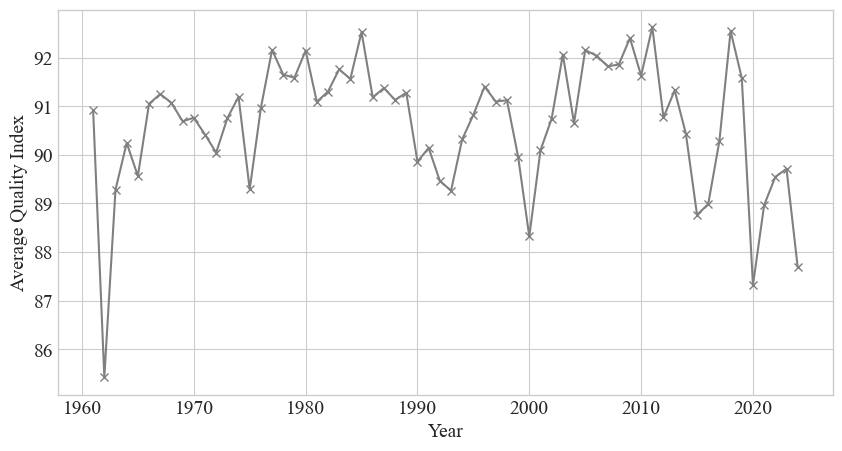

In [28]:
# Calculate the average quality index over the years
df_avg_quality_index = df_qc_info.groupby('year')['quality_index'].mean().reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the average quality index over the years
ax.plot(df_avg_quality_index['year'], df_avg_quality_index['quality_index'], marker='x', color='grey', label='Average Quality Index')

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index Over the Years')
ax.grid(True)

plt.savefig('./figures/quality_index_over_the_years.tiff', dpi=1800, bbox_inches='tight')
plt.show()
plt.close()

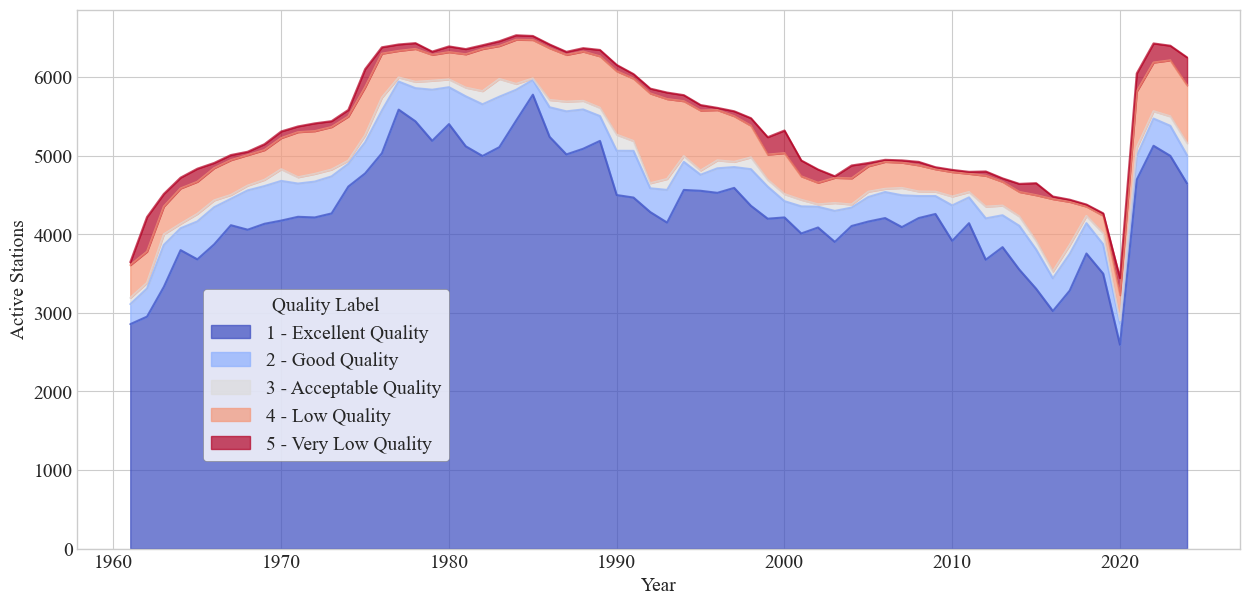

In [29]:

# Group by year and quality label to get the count of active stations
df_active_stations = df_qc_info.groupby(['year', 'quality_label']).size().unstack(fill_value=0)

# Create a stacked area plot with updated figure size
fig, ax = plt.subplots(figsize=(15, 7))

# Use a colorblind-friendly colormap
df_active_stations.plot(kind='area', stacked=True, ax=ax, colormap='coolwarm', alpha=0.7)

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Active Stations')
# ax.set_title('Count of Active Stations by Year and Quality Label')
ax.grid(True)

# Modify the EXISTING legend from pandas plot
legend = ax.legend()
legend.set_title('Quality Label')  # Set title
legend.set_bbox_to_anchor((0.1, 0.5))  # Set legend position
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

plt.savefig('./figures/active_stations_by_year_and_quality_label.tiff', dpi=1800, bbox_inches='tight')

plt.show()
plt.close()

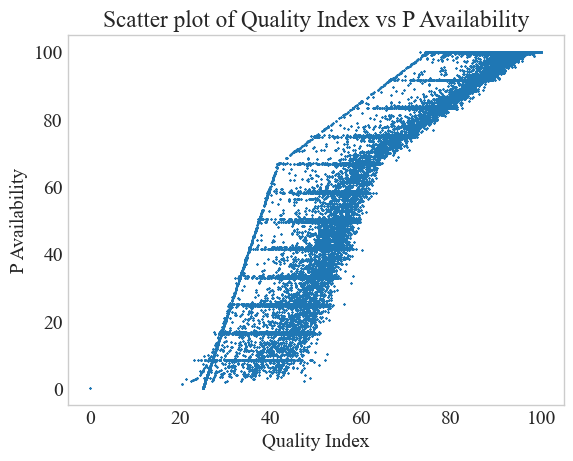

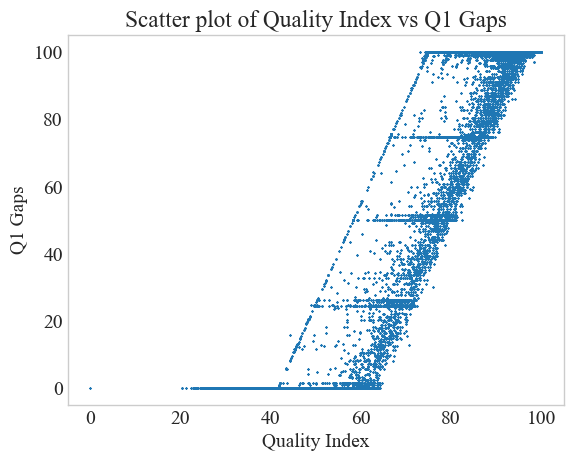

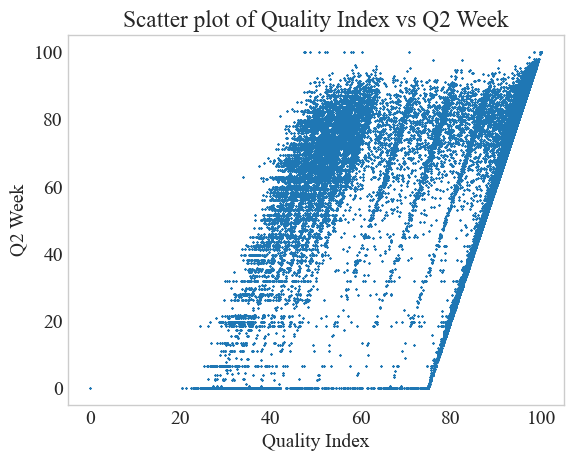

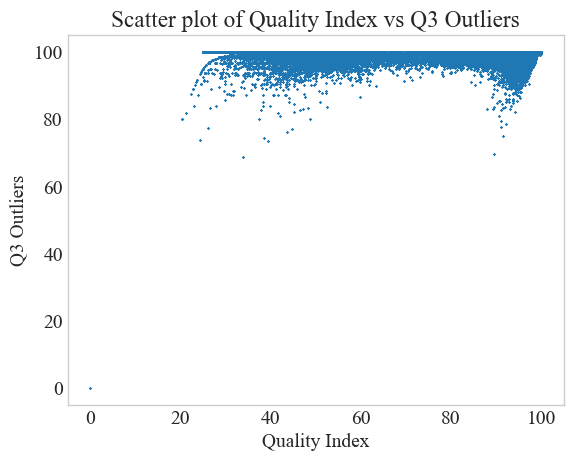

In [30]:
# Scatter plot for p_availability vs Quality Index
plt.scatter(df_qc_info['quality_index'], df_qc_info['p_availability'], marker='x', s=1)
plt.xlabel('Quality Index')
plt.ylabel('P Availability')
plt.title('Scatter plot of Quality Index vs P Availability')
plt.show()
plt.close()

# Scatter plot for q1_gaps vs Quality Index
plt.scatter(df_qc_info['quality_index'], df_qc_info['q1_gaps'], marker='x', s=1)
plt.xlabel('Quality Index')
plt.ylabel('Q1 Gaps')
plt.title('Scatter plot of Quality Index vs Q1 Gaps')
plt.show()
plt.close()

# Scatter plot for q2_week vs Quality Index
plt.scatter(df_qc_info['quality_index'], df_qc_info['q2_week'], marker='x', s=1)
plt.xlabel('Quality Index')
plt.ylabel('Q2 Week')
plt.title('Scatter plot of Quality Index vs Q2 Week')
plt.show()
plt.close()


plt.scatter(df_qc_info['quality_index'], df_qc_info['q3_outliers'], marker='x', s=1)
plt.xlabel('Quality Index')
plt.ylabel('Q3 Outliers')
plt.title('Scatter plot of Quality Index vs Q3 Outliers')
plt.show()
plt.close()